<a href="https://colab.research.google.com/github/vitoriapmaattos/techfase2/blob/main/FIAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Faculdade de Informática e Administração Paulista – FIAP**

**Grupo 47: Cristiano de Araujo Santos Filho, Eduardo Vilela Silva, Guilherme de Faria Rodrigues, Marcelo Pereira Varesi e Vitória Pinheiro de Mattos**

**INTRODUÇÃO**

No cenário dinâmico do mercado financeiro, a capacidade de prever os movimentos de um índice como o IBOVESPA é de suma importância para investidores e analistas. A previsão correta dos preços de fechamento diários pode fornecer insights valiosos para decisões de investimento, ajudando a mitigar riscos e maximizar retornos.

O objetivo do projeto foi desenvolver um modelo preditivo capaz de prever o fechamento diário do índice IBOVESPA. Após uma exploração dos dados e testes, foi decidido utilizar uma abordagem de série temporal, empregamos três técnicas distintas: XGBoost, Prophet e SARIMAX. Cada uma dessas técnicas possui características únicas que contribuem para a eficácia da previsão e, quando combinadas, permitem uma análise abrangente e detalhada.

Este documento detalha cada fase do projeto, desde a aquisição dos dados históricos do IBOVESPA até a implementação e avaliação dos modelos preditivos.

Nosso objetivo é atingir uma acurácia mínima de 70%.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import statsmodels.api as sm
import xgboost as xgb
import yfinance as yf

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

**IMPORTANDO E TRATANDO DADOS**

Os dados para análise foram coletados no site da investing.


Link: https://br.investing.com/indices/bovespa-historical-data

In [ ]:
#Importando Dados

df_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSsuIAiZ3bBY9sdQ2BBvkpfp70zzWzmr1py94pVAzU_5akd8yNxnA1tcY4m4GCmWAg3tOWVL_Pwh90e/pub?output=csv"

In [ ]:
df = pd.read_csv(df_path, parse_dates=[0], index_col='Data')
df = df.reset_index()
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Vol._At,Var%,Unnamed: 8,Unnamed: 9
0,11/03/2021,114.984,112.782,115.127,112.776,"12,09M","12,09","1,96%",NaN,"12,09"
1,10/03/2021,112.776,111.331,112.928,109.999,"12,51M","12,51","1,30%",NaN,"12,51"
2,09/03/2021,111.331,110.611,112.525,109.343,"12,14M","12,14","0,65%",NaN,"12,14"
3,08/03/2021,110.612,115.202,115.202,110.268,"13,70M","13,70","-3,98%",NaN,NaN
4,05/03/2021,115.202,112.690,115.504,112.504,"13,25M","13,25","2,23%",NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        4999 non-null   object 
 1   Último      4999 non-null   float64
 2   Abertura    4999 non-null   float64
 3   Máxima      4999 non-null   float64
 4   Mínima      4999 non-null   float64
 5   Vol.        4998 non-null   object 
 6   Vol._At     4998 non-null   object 
 7   Var%        4999 non-null   object 
 8   Unnamed: 8  0 non-null      float64
 9   Unnamed: 9  3 non-null      object 
dtypes: float64(5), object(5)
memory usage: 390.7+ KB


In [ ]:
#Adequando dados para modelos

df = df[['Data','Último', 'Abertura']]
df.columns=["ds", "y", "Open"]

In [ ]:
#Transformando coluna de data em tipo datetime

df["ds"] = pd.to_datetime(df["ds"], format="%d/%m/%Y")
df.set_index("ds", inplace=True)
df= df.asfreq('D', method='backfill')
df.head()

,y,Open
ds,,
2000-12-27,15.186,14.805
2000-12-28,15.259,15.188
2000-12-29,15.259,15.188
2000-12-30,15.259,15.188
2000-12-31,15.259,15.188


**ANÁLISE EXPLORATÓRIA DOS DADOS**

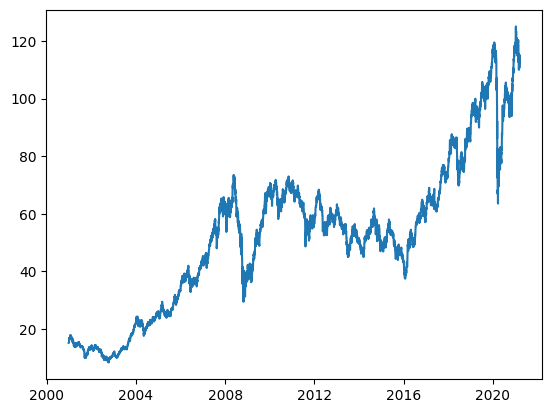

In [ ]:
#Explorando dados

plt.plot(df.index, df['y'])

Podemos notar dois declínios abruptos importantes no linha do tempo.



*   2008: Ocorreu devido a bolha imobiliária que atingiu os EUA, o aumento dos preços dos imóveis não foi acompanhado por um aumento na renda da população.
Fazendo com que o mercado financeiro brasileiro acumulasse **41,22% de perdas**.

*   2020: Devido as incertezas em razão dos efeitos da pandemia da Covid-19 na econimia, no primeiro trimestre deste ano podemos observar **uma queda de 36,86%**. Finalizamos este ano com uma alta de 3%.




**DECOMPOSIÇAO**

Na decomposição da série temporal, podemos identificar três componentes principais:
- Tendência
- Sazonalidade
- Resíduos

Os resultados obtidos não indicam uma tendência clara, mas apresentam uma sazonalidade anual dos dados.

In [ ]:
df_SD = df[['y']]

resultados = seasonal_decompose(df_SD, model='additive', period=365)

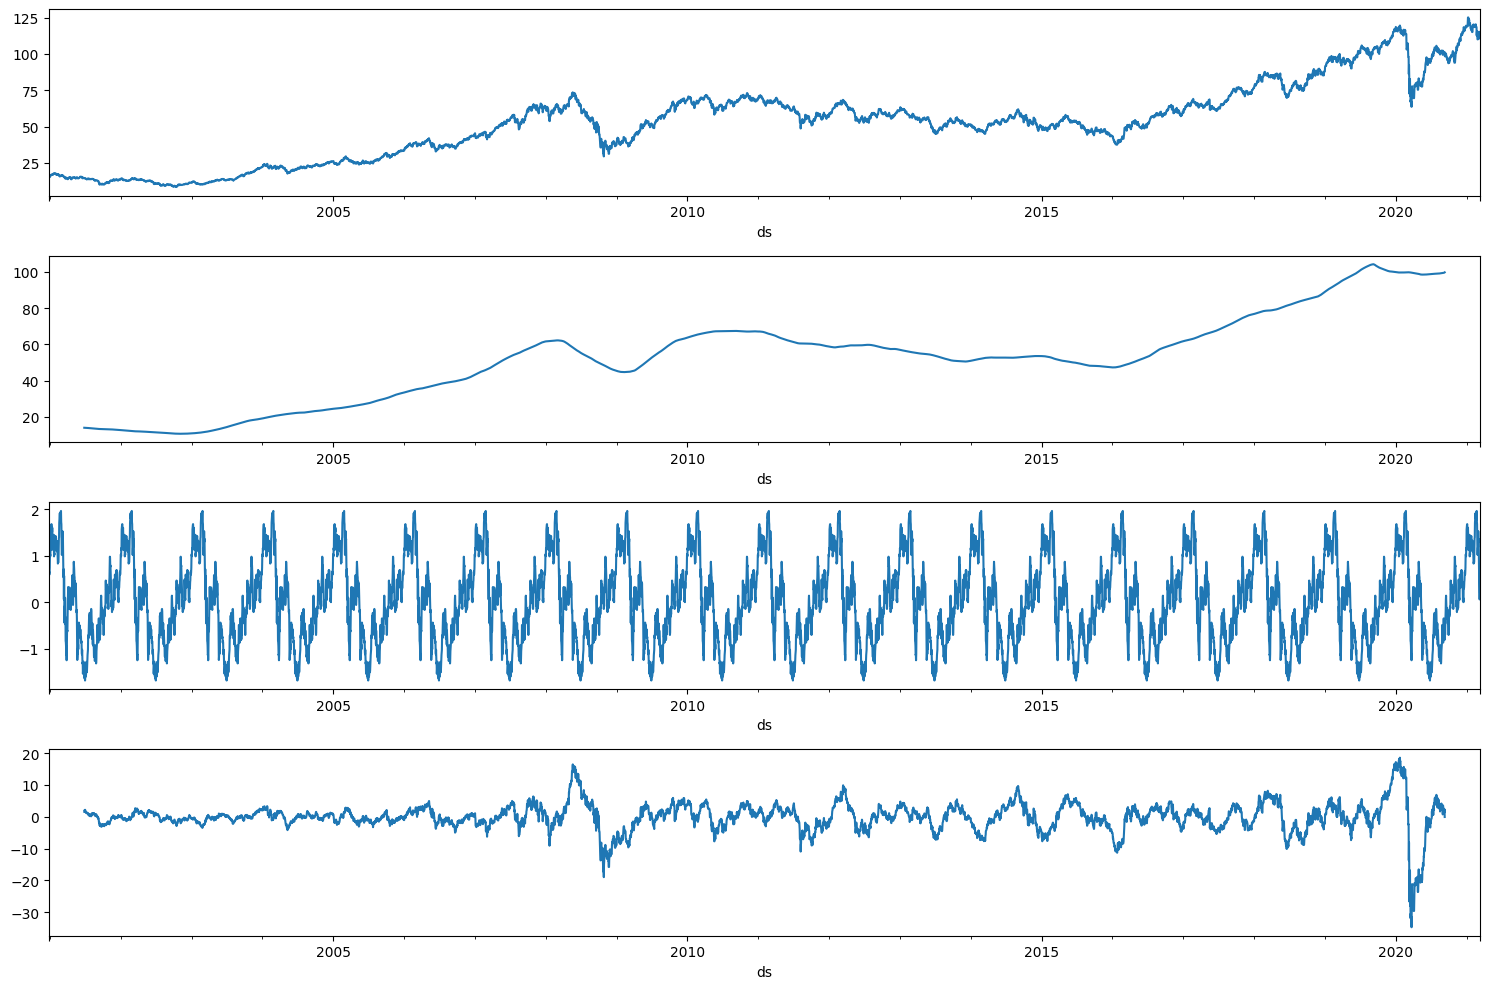

In [ ]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

In [ ]:
df_SD["y"].describe()

count    7380.000000
mean       52.413958
std        26.194216
min         8.371000
25%        33.545500
50%        53.911000
75%        66.125000
max       125.077000
Name: y, dtype: float64

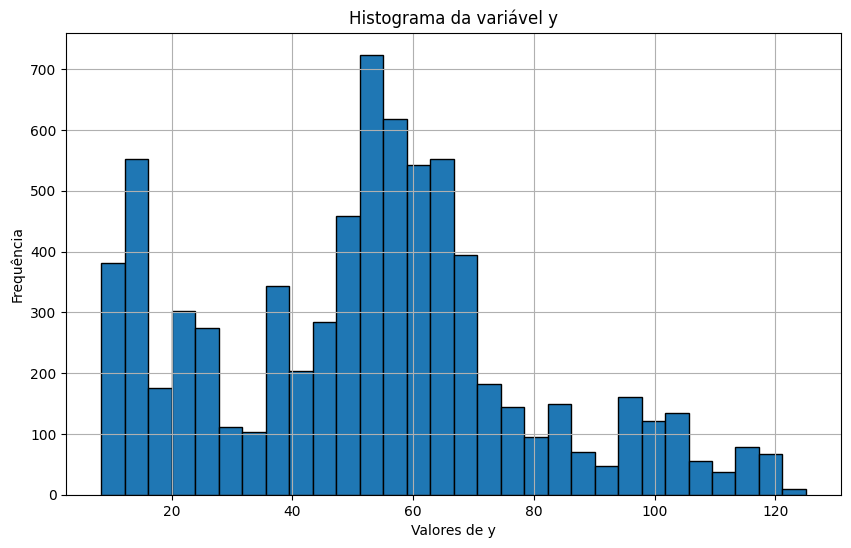

In [ ]:
# Criando o histograma
plt.figure(figsize=(10, 6))
plt.hist(df_SD['y'], bins=30, edgecolor='black')
plt.title('Histograma da variável y')
plt.xlabel('Valores de y')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

Quanto à descrição dos dados obtidos e o histograma, é possível perceber que:
- O desvio padrão de 26.19, comparado com a média de 52.41, indica uma variação significativa nos dados. Isto é,há uma dispersão considerável ao redor da média.
-A diferença entre o valor mínimo (8.37) e o valor máximo (125.08) mostra uma ampla faixa de valores.
- Não há uma distribuição simétrica dos valores

**TRANSFORMANDO EM ESTACIONÁRIA E TESTE DE AUTOCORRELACAO**

Para realizar o teste de autocorrelação transformamos a série temporal em estacionária, aplicando o LOG e a diferenciação.

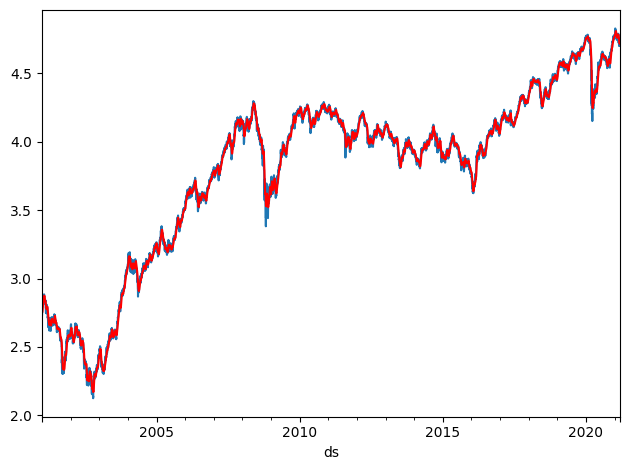

In [ ]:
#LOG
df_log = np.log(df_SD)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

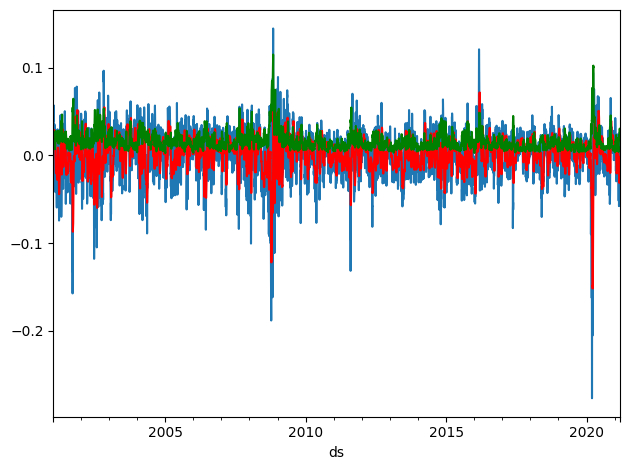

In [ ]:
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(12).mean()

std = df_s.rolling(12).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()


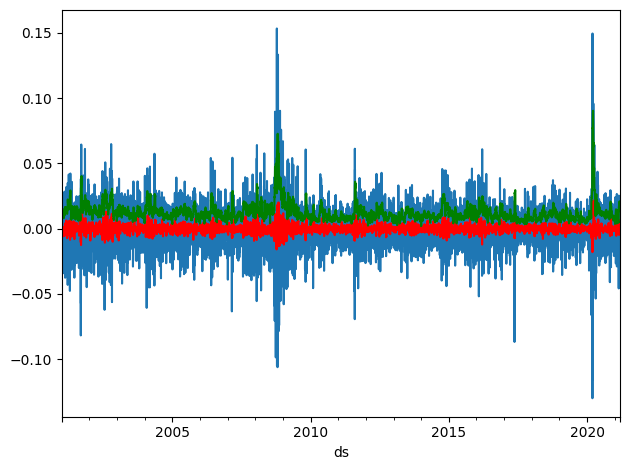

In [ ]:
#DIFF
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()

std_diff = df_diff.rolling(12).std()


f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

**CF E PACF**

Após obter as séries temporais estacionárias, podemos mediar a ACF (Autocorrelation Function) e a PACF (Partial Autocorrelation Function). Com essas analises podemos verificar se existe sazonalidade e randomicidade nos dados.

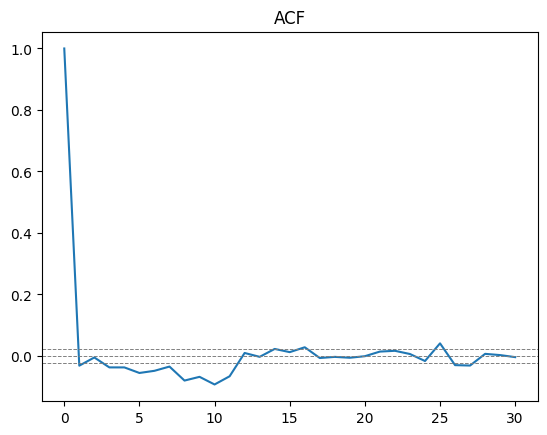

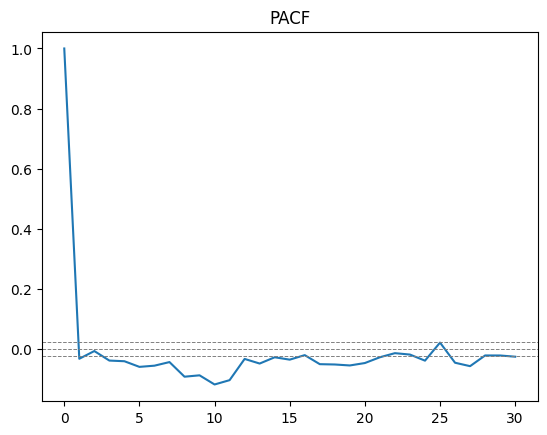

In [ ]:
#Plots de autocorrelação para determinar número de lags


lag_acf = acf(df_diff.dropna(), nlags=30)
lag_pacf = pacf(df_diff.dropna(), nlags=30)

plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("PACF")
plt.show()


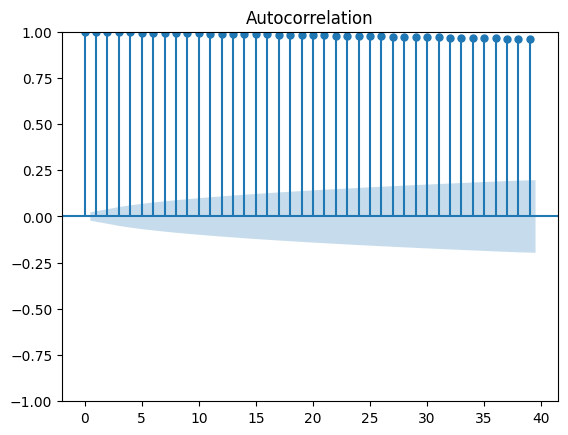

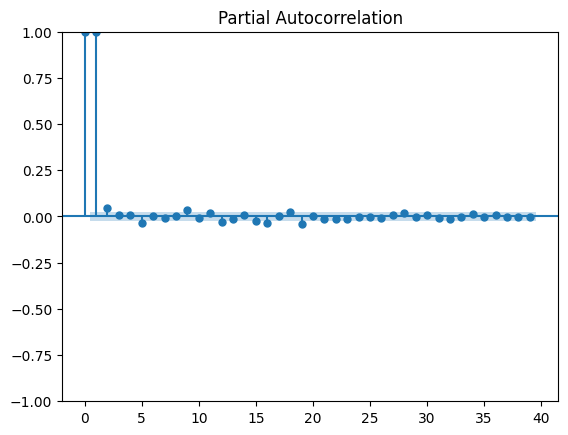

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['y'])
plot_pacf(df['y'])
plt.show()

Com estes resultados é possível chegar à conclusão de que modelos de baseline não são suficientes para alcançar uma previsão satisfatória. Portanto, escolhemos três modelos que lidam melhor com a rancomicidade dos dados, o Prophet, XGBoost e o Sarimax.

**MÉTRICAS DE AVALIAÇAO**

Nesta parte definimos métricas para avaliar a eficácia dos modelos utilizados. Essas serão: MAE (Mean Absolute Error), MSE (Mean Squared Error) e MAPE (Mean Absolute Percentage Error)

In [ ]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

**DIVISAO PARA TESTE E TREINO**

Para determinar a quantidade de dias que serão realizadas a predição, realizamos um backtesting com diferentes dias em um modelo. Chegamos ao valor fechado de 30 dias como uma possibilidade com um MAE aceitável.





In [ ]:
df.head()

,y,Open
ds,,
2000-12-27,15.186,14.805
2000-12-28,15.259,15.188
2000-12-29,15.259,15.188
2000-12-30,15.259,15.188
2000-12-31,15.259,15.188


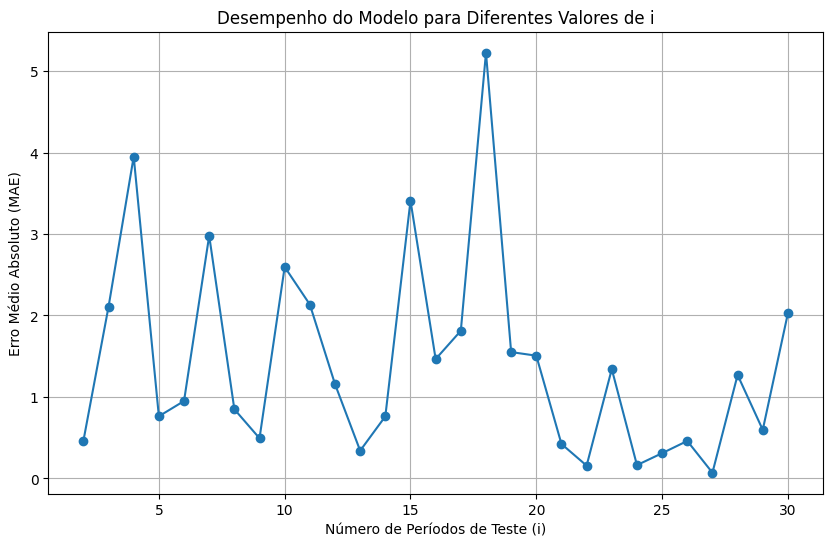

In [ ]:
df = df.reset_index()

FEATURES = ["year", "month", "day", "dayofweek", "Open"]
TARGET = "y"

# Preparação dos dados para XGBoost
def create_features(df):
    df["Date"] = pd.to_datetime(df["ds"])
    df["year"] = df["ds"].dt.year
    df["month"] = df["ds"].dt.month
    df["day"] = df["ds"].dt.day
    df["dayofweek"] = df["ds"].dt.dayofweek
    return df



# Listas para armazenar as métricas de desempenho
mae_scores = []

# Loop de backtesting
for i in range(30, 1, -1):
    train_size = df.shape[0] - i
    train, test = df[:train_size], df[train_size : train_size + 1]

    train = create_features(train)
    test = create_features(test)

    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]

    reg = xgb.XGBRegressor(objective="reg:squarederror")
    reg.fit(X_train, y_train)

    preds = reg.predict(X_test)

    # Calcular e armazenar a métrica de desempenho (MAE neste caso)
    mae = mean_absolute_error(y_test, preds)
    mae_scores.append(mae)

# Plotar MAE vs. Valor de i
plt.figure(figsize=(10, 6))
plt.plot(range(30, 1, -1), mae_scores, marker='o')
plt.xlabel('Número de Períodos de Teste (i)')
plt.ylabel('Erro Médio Absoluto (MAE)')
plt.title('Desempenho do Modelo para Diferentes Valores de i')
plt.grid(True)
plt.show()


In [ ]:


# Dividindo em treino e teste
train_size = df.shape[0] - 30
train, test = df[:train_size], df[train_size:]

train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek", "Open"]
TARGET = "y"

In [ ]:
df

,ds,y,Open
0,2000-12-27,15.186,14.805
1,2000-12-28,15.259,15.188
2,2000-12-29,15.259,15.188
3,2000-12-30,15.259,15.188
4,2000-12-31,15.259,15.188
...,...,...,...
7375,2021-03-07,115.202,112.690
7376,2021-03-08,110.612,115.202
7377,2021-03-09,111.331,110.611
7378,2021-03-10,112.776,111.331


**XGBOOST**

O modelo XGBoost (Extreme Gradient Boosting) é um algoritmo de aprendizado de máquina baseado em árvores de decisão, conhecido por sua eficiência e precisão. Ele é amplamente utilizado em competições de aprendizado de máquina devido à sua capacidade de lidar com dados desbalanceados e realizar previsões robustas.

**Parâmetros utilizados:**

Objective: "reg"

**Período de Previsão:**

7.366 dias

**Período de Treinamento e Teste:**

Treinamento: Até 2021-02-09
Teste: De 2021-02-10 até 2021-03-11

XGBoost Metrics:
MAE: 1.4463774047851559
MSE: 3.787183810609162
MAPE: 1.2716051753150956


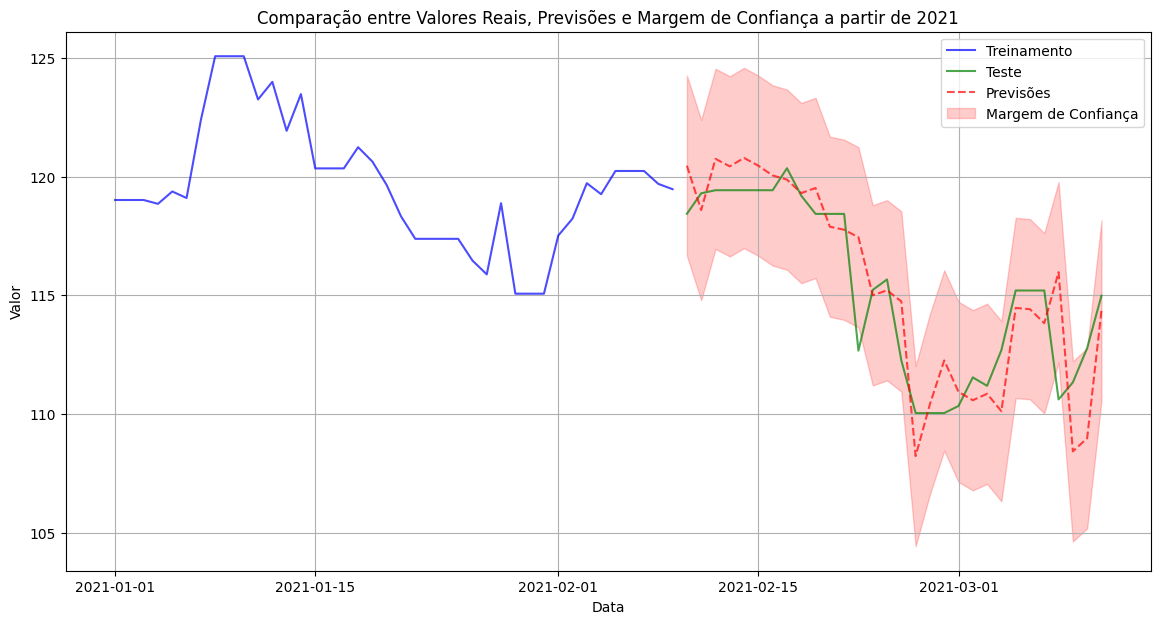

In [ ]:
# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

# Verificar se a coluna 'Date' está no formato datetime
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Filtrar os dados para incluir apenas datas a partir de 2021
start_date = '2021-01-01'
train_filtered_xgboost = train[train['Date'] >= start_date]
test_filtered_xgboost = test[test['Date'] >= start_date]

# Calcular erros das previsões
errors = y_test - preds

# Calcular o erro padrão dos erros
std_error = np.std(errors)

# Definir o intervalo de confiança (95% aproximadamente 1.96 desvios padrão)
confidence_interval = 1.96 * std_error

# Adicionar previsões e margens ao DataFrame de teste filtrado
test_filtered_xgboost['Predictions'] = preds
test_filtered_xgboost['Upper_Bound'] = preds + confidence_interval
test_filtered_xgboost['Lower_Bound'] = preds - confidence_interval

# Plotar XGBOOST
plt.figure(figsize=(14, 7))

# Plotar valores reais de treino filtrados
plt.plot(train_filtered_xgboost['Date'], train_filtered_xgboost[TARGET], label='Treinamento', color='blue', alpha=0.7)

# Plotar valores reais de teste filtrados
plt.plot(test_filtered_xgboost['Date'], test_filtered_xgboost[TARGET], label='Teste', color='green', alpha=0.7)

# Plotar previsões filtradas
plt.plot(test_filtered_xgboost['Date'], test_filtered_xgboost['Predictions'], label='Previsões', color='red', linestyle='--', alpha=0.7)

# Plotar a margem de confiança
plt.fill_between(test_filtered_xgboost['Date'], test_filtered_xgboost['Lower_Bound'], test_filtered_xgboost['Upper_Bound'], color='red', alpha=0.2, label='Margem de Confiança')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Comparação entre Valores Reais, Previsões e Margem de Confiança a partir de 2021')
plt.legend()
plt.grid(True)
plt.show()


**PROPHET**

O modelo Prophet é desenvolvido pelo Facebook e é usado para a previsão de séries temporais. Ele é particularmente útil quando se lida com dados que apresentam sazonalidades diárias, semanais e anuais, além de efeitos de feriados. Prophet permite adicionar regressoras para melhorar a precisão das previsões.

**Parâmetros utilizados:**

Sazonalidade diária, semanal e anual
Regressora: "Open"

**Período de Previsão:**

7.366 dias

**Período de Treinamento e Teste:**

Treinamento: Até 2021-02-09 Teste: De 2021-02-10 até 2021-03-11

In [ ]:
# Modelo Prophet
train_prophet = train[['ds', 'y', 'Open']]
test_prophet = test[['ds', 'y', 'Open']]

train_prophet

,ds,y,Open
0,2000-12-27,15.186,14.805
1,2000-12-28,15.259,15.188
2,2000-12-29,15.259,15.188
3,2000-12-30,15.259,15.188
4,2000-12-31,15.259,15.188
...,...,...,...
7345,2021-02-05,120.240,119.261
7346,2021-02-06,120.240,119.261
7347,2021-02-07,120.240,119.261
7348,2021-02-08,119.696,120.239


DEBUG:cmdstanpy:input tempfile: /tmp/tmphftzh9tv/84y2ab3m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphftzh9tv/cqhl4v5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31800', 'data', 'file=/tmp/tmphftzh9tv/84y2ab3m.json', 'init=/tmp/tmphftzh9tv/cqhl4v5h.json', 'output', 'file=/tmp/tmphftzh9tv/prophet_modelw7ygg048/prophet_model-20240729200035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Metrics:
MAE: 1.528751479591675
MSE: 4.017050943539056
MAPE: 1.3452741934169434


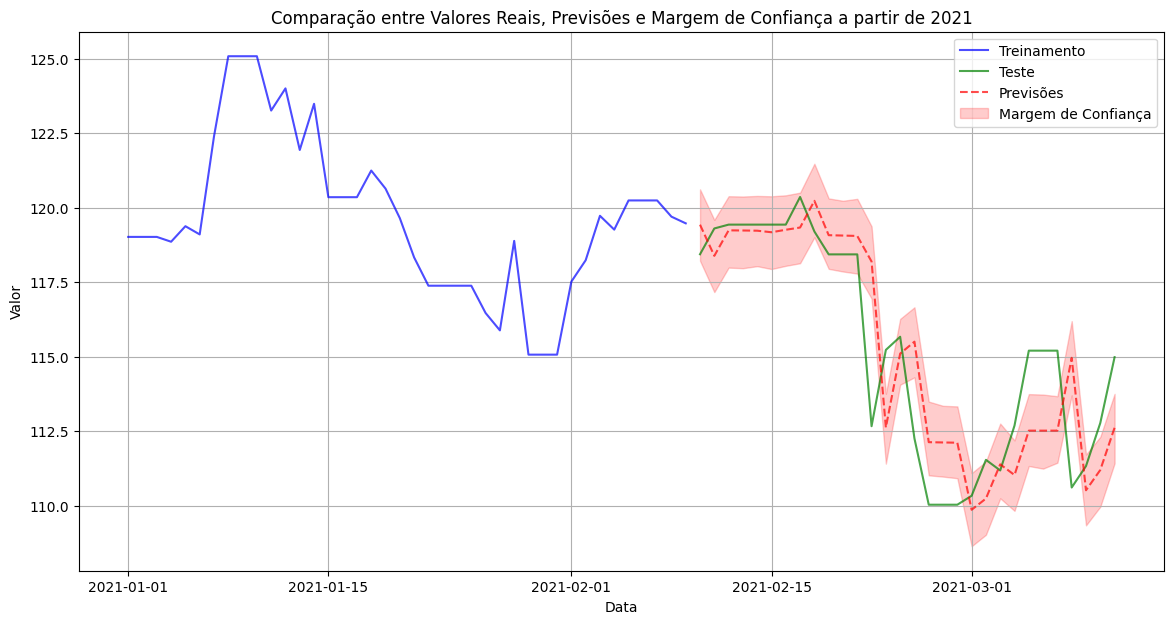

In [ ]:

model = Prophet(daily_seasonality=True)
model.add_regressor("Open")
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
future["Open"] = pd.concat([train["Open"], test["Open"]], ignore_index=True)
forecast = model.predict(future)

preds = forecast[["ds", "yhat"]].tail(len(test))
preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

# Filtrar previsões para o período de teste
forecast_filtered = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_filtered = forecast_filtered.tail(len(test))
forecast_filtered = forecast_filtered.set_index("ds")

# Filtrar para incluir apenas datas a partir de 2021
start_date = '2021-01-01'
forecast_filtered_prophet = forecast_filtered[forecast_filtered.index >= start_date]
test_prophet = test_prophet[test_prophet['ds'] >= start_date]
train_prophet = train_prophet[train_prophet['ds'] >= start_date]

# Ajustar y_test
y_test = test_prophet.set_index("ds")["y"]

# Calcular métricas (defina suas funções 'calculate_metrics' e 'print_metrics' se ainda não estiverem definidas)
metrics_pr = calculate_metrics(y_test, forecast_filtered_prophet["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

# Plotar PROPHET
plt.figure(figsize=(14, 7))

# Plotar valores reais de treino
plt.plot(train_prophet['ds'], train_prophet['y'], label='Treinamento', color='blue', alpha=0.7)

# Plotar valores reais de teste
plt.plot(test_prophet['ds'], test_prophet['y'], label='Teste', color='green', alpha=0.7)

# Plotar previsões
plt.plot(forecast_filtered_prophet.index, forecast_filtered_prophet['yhat'], label='Previsões', color='red', linestyle='--', alpha=0.7)

# Plotar intervalo de confiança
plt.fill_between(forecast_filtered_prophet.index, forecast_filtered_prophet['yhat_lower'], forecast_filtered_prophet['yhat_upper'], color='red', alpha=0.2, label='Margem de Confiança')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Comparação entre Valores Reais, Previsões e Margem de Confiança a partir de 2021')
plt.legend()
plt.grid(True)
plt.show()

**SARRIMAX**

O modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) é uma extensão do ARIMA que incorpora componentes sazonais e regressoras exógenas. Ele é adequado para séries temporais com padrões sazonais e onde variáveis externas influenciam as previsões.

**Parâmetros utilizados:**

Ordem: (1, 1, 1)
Ordem sazonal: (1, 1, 1, 12)
Regressora: "Open"

**Período de Previsão:**

7.366 dias

**Período de Treinamento e Teste:**

Treinamento: Até 2021-02-09 Teste: De 2021-02-10 até 2021-03-11



SARIMAX Metrics:
MAE: 4.830939322586229
MSE: 38.14924832842498
MAPE: 4.300910357917007


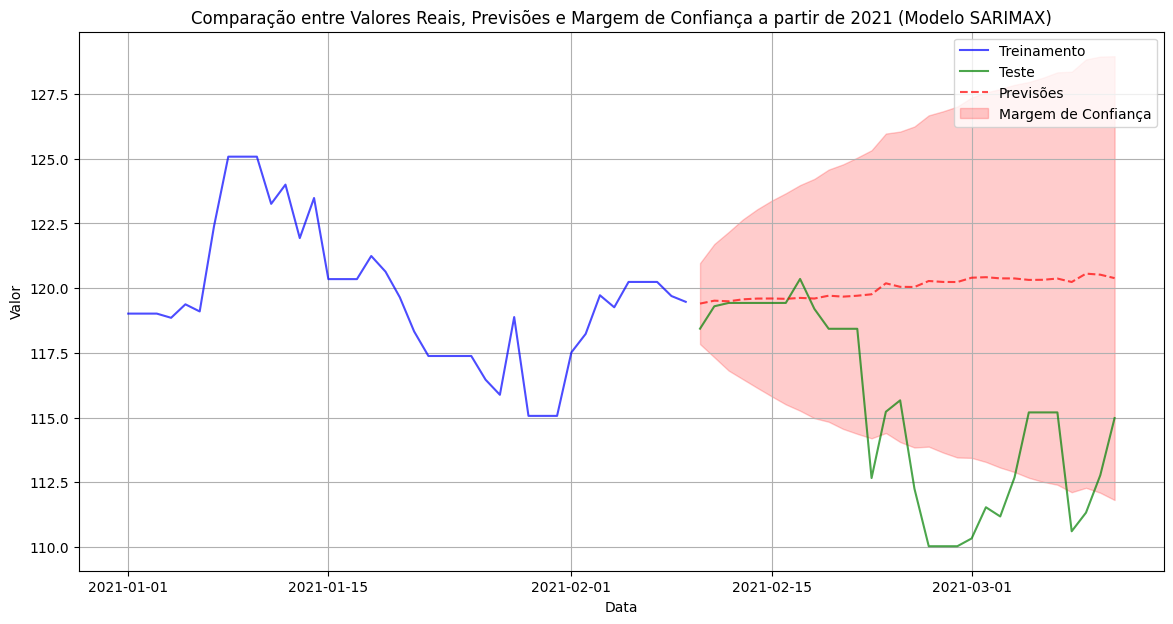

In [ ]:
# Modelo SARIMAX
exog_train = train[["Open"]]
exog_test = test[["Open"]]

model = sm.tsa.statespace.SARIMAX(
    train["y"], exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)
)
results = model.fit()

forecast = results.get_forecast(steps=len(test), exog=exog_test)
preds = forecast.predicted_mean
conf_int = forecast.conf_int()

# Ajustar o índice das previsões para corresponder às datas de teste
preds.index = test["ds"]
conf_int.index = test["ds"]

test_metrics = test.set_index("ds")

metrics_sarimax = calculate_metrics(test_metrics["y"], preds)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

# Filtrar previsões para o período de teste
forecast_filtered = preds
conf_int_filtered = conf_int
test_filtered_sarimax = test.set_index("ds")
train_filtered_sarimax = train.set_index("ds")

# Converter índices para datetime
forecast_filtered.index = pd.to_datetime(forecast_filtered.index)
conf_int_filtered.index = pd.to_datetime(conf_int_filtered.index)
test_filtered_sarimax.index = pd.to_datetime(test_filtered_sarimax.index)
train_filtered_sarimax.index = pd.to_datetime(train_filtered_sarimax.index)

# Filtrar para incluir apenas datas a partir de 2021
start_date = pd.to_datetime('2021-01-01')
forecast_filtered = forecast_filtered[forecast_filtered.index >= start_date]
conf_int_filtered = conf_int_filtered[conf_int_filtered.index >= start_date]
test_filtered_sarimax = test_filtered_sarimax[test_filtered_sarimax.index >= start_date]
train_filtered_sarimax = train_filtered_sarimax[train_filtered_sarimax.index >= start_date]

# Plotar SARIMAX
plt.figure(figsize=(14, 7))

# Plotar valores reais de treino
plt.plot(train_filtered_sarimax.index, train_filtered_sarimax['y'], label='Treinamento', color='blue', alpha=0.7)

# Plotar valores reais de teste
plt.plot(test_filtered_sarimax.index, test_filtered_sarimax['y'], label='Teste', color='green', alpha=0.7)

# Plotar previsões
plt.plot(forecast_filtered.index, forecast_filtered, label='Previsões', color='red', linestyle='--', alpha=0.7)

# Plotar intervalo de confiança
plt.fill_between(conf_int_filtered.index, conf_int_filtered.iloc[:, 0], conf_int_filtered.iloc[:, 1], color='red', alpha=0.2, label='Margem de Confiança')

plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Comparação entre Valores Reais, Previsões e Margem de Confiança a partir de 2021 (Modelo SARIMAX)')
plt.legend()
plt.grid(True)
plt.show()
plot_sarimax = plt

**RESULTADOS E CONCLUSÃO**

         XGBoost  PR Model    SARIMAX
Metric                               
MAE     1.446377  1.528751   4.830939
MSE     3.787184  4.017051  38.149248
MAPE    1.271605  1.345274   4.300910


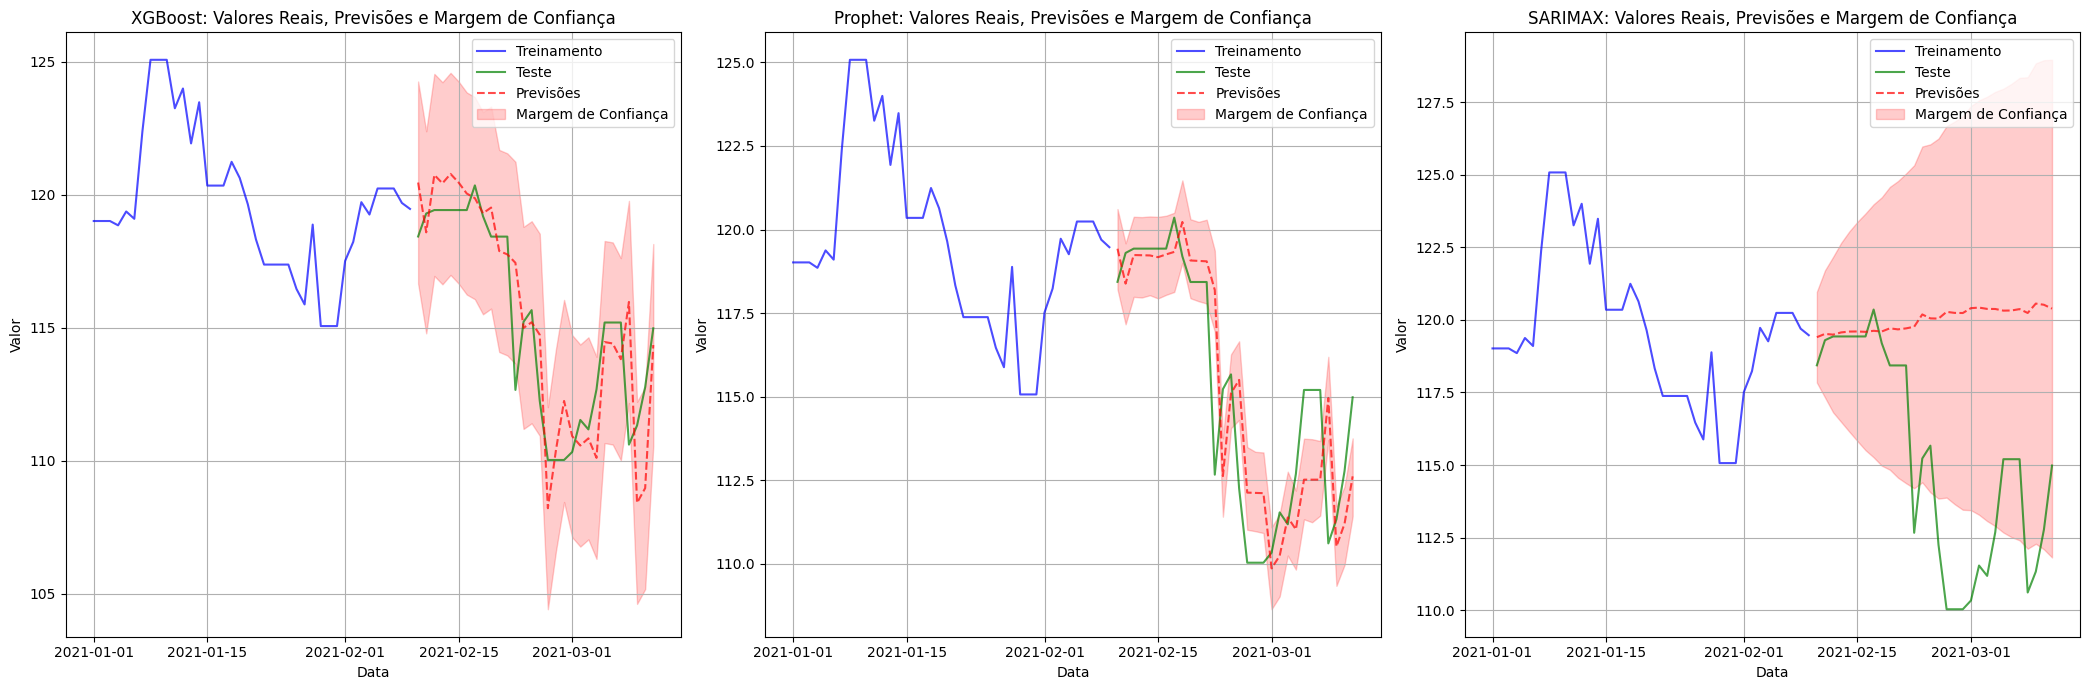

In [ ]:

metric_names = ['MAE', 'MSE', 'MAPE']

df_metrics = pd.DataFrame({
    'Metric': metric_names,
    'XGBoost': metrics_xgb,
    'PR Model': metrics_pr,
    'SARIMAX': metrics_sarimax
})

#
df_metrics.set_index('Metric', inplace=True)

# Exibindo a tabela das metricas de cada modelo
print(df_metrics)
plot_sarimax.show()

fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Plotar XGBoost
axs[0].plot(train_filtered_xgboost['Date'], train_filtered_xgboost[TARGET], label='Treinamento', color='blue', alpha=0.7)
axs[0].plot(test_filtered_xgboost['Date'], test_filtered_xgboost[TARGET], label='Teste', color='green', alpha=0.7)
axs[0].plot(test_filtered_xgboost['Date'], test_filtered_xgboost['Predictions'], label='Previsões', color='red', linestyle='--', alpha=0.7)
axs[0].fill_between(test_filtered_xgboost['Date'], test_filtered_xgboost['Lower_Bound'], test_filtered_xgboost['Upper_Bound'], color='red', alpha=0.2, label='Margem de Confiança')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Valor')
axs[0].set_title('XGBoost: Valores Reais, Previsões e Margem de Confiança')
axs[0].legend()
axs[0].grid(True)

# Plotar Prophet
axs[1].plot(train_prophet['ds'], train_prophet['y'], label='Treinamento', color='blue', alpha=0.7)
axs[1].plot(test_prophet['ds'], test_prophet['y'], label='Teste', color='green', alpha=0.7)
axs[1].plot(forecast_filtered_prophet.index, forecast_filtered_prophet['yhat'], label='Previsões', color='red', linestyle='--', alpha=0.7)
axs[1].fill_between(forecast_filtered_prophet.index, forecast_filtered_prophet['yhat_lower'], forecast_filtered_prophet['yhat_upper'], color='red', alpha=0.2, label='Margem de Confiança')
axs[1].set_xlabel('Data')
axs[1].set_ylabel('Valor')
axs[1].set_title('Prophet: Valores Reais, Previsões e Margem de Confiança')
axs[1].legend()
axs[1].grid(True)

# Plotar SARIMAX
axs[2].plot(train_filtered_sarimax.index, train_filtered_sarimax['y'], label='Treinamento', color='blue', alpha=0.7)
axs[2].plot(test_filtered_sarimax.index, test_filtered_sarimax['y'], label='Teste', color='green', alpha=0.7)
axs[2].plot(forecast_filtered.index, forecast_filtered, label='Previsões', color='red', linestyle='--', alpha=0.7)
axs[2].fill_between(conf_int_filtered.index, conf_int_filtered.iloc[:, 0], conf_int_filtered.iloc[:, 1], color='red', alpha=0.2, label='Margem de Confiança')
axs[2].set_xlabel('Data')
axs[2].set_ylabel('Valor')
axs[2].set_title('SARIMAX: Valores Reais, Previsões e Margem de Confiança')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

Após os testes, é possível perceber que o modelo que desempenhou melhor foi o XGBoost, provavelmente por lidar melhor com randomicidades. Além disso, nos gráficos, sua margem de erro foi a que melhor comportou os valores reais.